In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
import pandas as pd
from datetime import datetime
import firebase_admin
from firebase_admin import db
from firebase_admin import credentials
import pytz


# Import from Firebase

To download data from firebase, you must have a unique key stored locally. The key will not be available from github and should not be uploaded to github. The following code currently downloads all the data from Firebase, as our database grows, future versions should look into only downloading the latest data.

In [2]:
### ONLY RUN ONCE! ###
#download data from firebase
cred = credentials.Certificate("../pc_basestation/fb_key.json")
firebase_admin.initialize_app(cred, {'databaseURL': 'https://haucs-monitoring-default-rtdb.firebaseio.com'})

In [22]:
## ONLY RUN TO REFRESH DATA! ###
ref = db.reference('/')
data = ref.get()

### RUN TO SAVE JSON FILE LOCALLY ###
with open('latest_data.json', 'w') as f:
    json.dump(data, f)

## Date Time
Firebase stores the time of data entries as a local datetime string. Due to daylight savings issues, we have to be careful with how to process datetime objects. The following code block handles converting local datetime objects into timezone aware datetime objects.

For data analysis, the date time objects should probably be converted into timestamps.

In [23]:
def to_datetime(dates, tz_aware=True):
    dt = []
    for i in dates:
        if 'T' in i or '-' in i:
            i = i.replace('T','_')
            i = i.replace('-','')
        i_dt = datetime.strptime(i, '%Y%m%d_%H:%M:%S')
        if tz_aware:
            tz = pytz.timezone('US/Eastern')
            i_dt = tz.localize(i_dt)

        dt.append(i_dt)
    return dt

#time
example = datetime.fromisoformat("2023-03-12T01:30:05")
#time zone aware current time
#example_aware = to_datetime([str(example)])[0]

print("unaware time: ", example)
print("aware time: ", example_aware)

print("unaware timestamp", example.timestamp())
print("aware timestamp", example_aware.timestamp())

unaware time:  2023-03-12 01:30:05
aware time:  2023-03-12 01:30:05-05:00
unaware timestamp 1678602605.0
aware timestamp 1678602605.0


# Local Data

Harvest results and sensor anomalies are recorded locally. The sensor log file keeps track of any anomalies that occur with the sensor.

| Event | Description | Value |
| - | - | - |
| i | installed in a tank | tank installed in |
| r | removed from a tank | tank removed from |
| c | debris cleaned from sensor | N/A |
| f | sensor failure leading to missing data | N/A |


In [30]:
## information regarding sensor installments/removals
## ID - biomass sensor (not algae tank)
df_anomaly = pd.read_csv('sensor_log.csv')
df_anomaly['datetime'] = to_datetime(df_anomaly.Date)

## information regarding algae harvests
## Before - algae (kg) in tank before harvest
## After  - algae (kg) in tank after harvest
## ID - algae tank
df_harvest = pd.read_csv('harvest_log.csv')
df_harvest['datetime'] = to_datetime(df_harvest.Date)
print(df_anomaly.head())
print("\n", df_harvest.head())

                  Date  ID Event  Value                  datetime
0  2023-04-11T09:00:00   1     r    1.0 2023-04-11 09:00:00-04:00
1  2023-04-11T13:30:00   1     i    2.0 2023-04-11 13:30:00-04:00
2  2023-04-12T17:30:00   3     f    NaN 2023-04-12 17:30:00-04:00
3  2023-04-13T10:00:00   2     r    1.0 2023-04-13 10:00:00-04:00
4  2023-04-13T18:00:00   2     i    2.0 2023-04-13 18:00:00-04:00

                   Date  ID  Before  After                  datetime
0  2023-02-03T12:00:00   3   39.71  22.11 2023-02-03 12:00:00-05:00
1  2023-02-09T12:00:00   3   36.90  22.11 2023-02-09 12:00:00-05:00
2  2023-02-16T12:00:00   3   46.30  22.11 2023-02-16 12:00:00-05:00
3  2023-02-22T12:00:00   3   43.01  22.11 2023-02-22 12:00:00-05:00
4  2023-03-02T12:00:00   3   44.40  22.11 2023-03-02 12:00:00-05:00


# Processing Sensor Data

In [31]:
def moving_average(x, n=4):
    '''
    Simple moving average filter
    '''
    filter = np.ones(n) / n
    return np.convolve(x, filter, 'same')

class bmass_sensor():

    def __init__(self, name, data):
        self.d_dt = to_datetime(data[name]['data'])
        self.s_dt = to_datetime(data[name]['status'])
        self.on = np.array([int(data[name]['data'][i][1]) for i in data[name]['data']])
        self.off = np.array([int(data[name]['data'][i][0]) for i in data[name]['data']])
        self.g = np.array([int(data[name]['data'][i][2]) for i in data[name]['data']])
        self.battv = np.array([float(data[name]['status'][i]['batt_v']) for i in data[name]['status']])


bm1 = bmass_sensor('bmass_1', data)
bm2 = bmass_sensor('bmass_2', data)
bm3 = bmass_sensor('bmass_3', data)
bm4 = bmass_sensor('bmass_4', data)
bm5 = bmass_sensor('bmass_5', data)


In [32]:
print("bm1: ", bm1.d_dt[-1], " ", bm1.on[-1], " ", bm1.off[-1], " ", bm1.g[-1])
print("bm2: ", bm2.d_dt[-1], " ", bm2.on[-1], " ", bm2.off[-1], " ", bm2.g[-1])
print("bm3: ", bm3.s_dt[-1], " ", bm3.on[-1], " ", bm3.off[-1], " ", bm3.g[-1])
print("bm4: ", bm4.d_dt[-1], " ", bm4.on[-1], " ", bm4.off[-1], " ", bm4.g[-1])
print("bm5: ", bm5.d_dt[-1], " ", bm5.on[-1], " ", bm5.off[-1], " ", bm5.g[-1])

bm1:  2023-04-18 09:09:21-04:00   202   161   1398
bm2:  2023-04-18 09:11:04-04:00   516   198   15041
bm3:  2023-04-16 21:02:55-04:00   129   0   5462
bm4:  2023-04-18 09:04:29-04:00   209   131   3126
bm5:  2023-04-18 09:02:18-04:00   531   252   7005


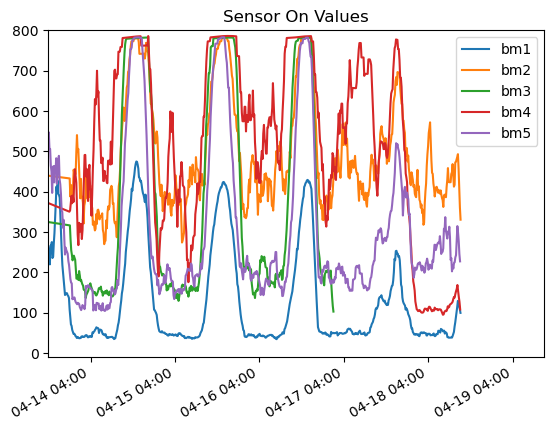

In [33]:
# Set date format for x-axis labels
date_fmt = '%m-%d %H:%M'
# Use DateFormatter to set the data to the correct format.
date_formatter = mdates.DateFormatter(date_fmt)


lower = datetime(2023, 4, 13, hour=16)
#plot
plt.figure()
plt.plot(bm1.d_dt, moving_average(bm1.on, 10))
plt.plot(bm2.d_dt, moving_average(bm2.on, 10))
plt.plot(bm3.d_dt, moving_average(bm3.on, 10))
plt.plot(bm4.d_dt, moving_average(bm4.on, 10))
plt.plot(bm5.d_dt, moving_average(bm5.on, 10))
plt.xlim(left=lower)
plt.ylim(top=800)
plt.title("Sensor On Values")
plt.legend(['bm1','bm2', 'bm3', 'bm4', 'bm5'])
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_formatter)
plt.show()

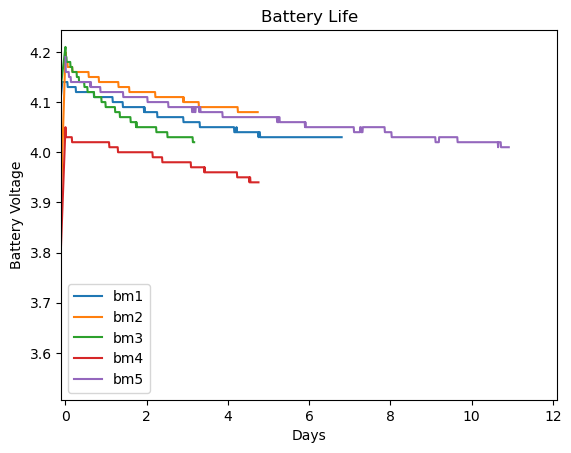

In [34]:
bm1_t = mdates.date2num(bm1.s_dt)
bm2_t = mdates.date2num(bm2.s_dt)
bm3_t = mdates.date2num(bm3.s_dt)
bm4_t = mdates.date2num(bm4.s_dt)
bm5_t = mdates.date2num(bm5.s_dt)

bm1_start = bm1_t[1633]
bm2_start = bm2_t[812]
bm3_start = bm3_t[723]
bm4_start = bm4_t[755]
bm5_start = bm5_t[0]


bm1_t = bm1_t - bm1_start
bm2_t = bm2_t - bm2_start
bm3_t = bm3_t - bm3_start
bm4_t = bm4_t - bm4_start
bm5_t = bm5_t - bm5_start

t = np.arange(1, len(bm2.battv) + 1) / 6 / 24
plt.figure()
plt.plot(bm1_t, bm1.battv)
plt.plot(bm2_t, bm2.battv)
plt.plot(bm3_t, bm3.battv)
plt.plot(bm4_t, bm4.battv)
plt.plot(bm5_t, bm5.battv)
plt.xlim(left=-.1)
plt.title("Battery Life")
plt.ylabel("Battery Voltage")
plt.xlabel("Days")
plt.legend(["bm1", "bm2", "bm3", "bm4", "bm5"], loc='lower left')
plt.show()

Int64Index([9, 10, 11], dtype='int64')
r
i
i


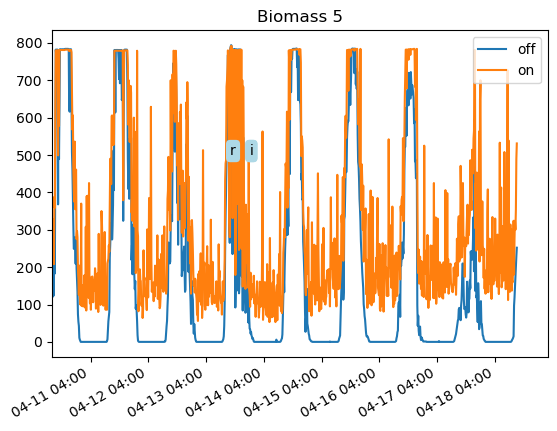

In [39]:
id = 5
bmx = bm5
lower = datetime(2023, 4, 10, hour=12)
#plot
plt.figure()
plt.plot(bmx.d_dt, bmx.off)
plt.plot(bmx.d_dt, bmx.on)
plt.xlim(left=lower)
# plt.ylim(top=400)
plt.title("Biomass " + str(id))
plt.legend(['off', 'on'])
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_formatter)

#plot anomalies 
bmx_anomalies = df_anomaly.index[df_anomaly.ID == id]
print(bmx_anomalies)
for i in bmx_anomalies:
    print(df_anomaly.Event[i])
    text = str(df_anomaly.Event[i])
    pos = df_anomaly.datetime[i]
    plt.text(pos, 500, text,
                bbox=dict(boxstyle="round,pad=0.3", ec='none', fc='lightblue'))
plt.show()

# Deleting Data from Firebase

**WARNING**: this action will permanently alter the data in Firebase.

In [87]:
#select sensor and data or status path
del_path = '/bmass_5/data'
del_node = db.reference(del_path)
#select start date for delete 
del_start = datetime(2023, 4, 13, hour=10, minute=0)
#select end date for delete
del_end = datetime(2023, 4, 13, hour=18, minute=0)

del_data = del_node.get()
del_data_dt = []
print("Deleting the Following Nodes: ", del_path)
for i in del_data:
    i_dt = datetime.fromisoformat(i)
    if (del_start <= i_dt <= del_end):
        print(i)
        del_data_dt.append(i)
        
#uncomment the following section to delete
print("Should these nodes be deleted? (y/n)")
# if (input('permanently delete (y/n): ') == 'y'):
#     for i in del_data_dt:
#         del_point = del_path + '/' + i
#         del_point = db.reference(del_point)
#         del_point.delete()

Deleting the Following Nodes:  /bmass_5/data
20230413_10:01:34
20230413_10:13:05
20230413_10:24:35
20230413_10:36:06
20230413_10:48:01
20230413_10:59:31
20230413_11:11:02
20230413_11:22:32
20230413_11:34:03
20230413_11:45:34
20230413_11:57:05
20230413_12:08:37
20230413_12:20:07
20230413_12:31:38
20230413_12:43:09
20230413_12:54:40
20230413_13:06:10
20230413_13:17:41
20230413_13:29:03
20230413_13:40:33
20230413_13:52:04
20230413_14:03:35
20230413_14:15:06
20230413_14:26:38
20230413_14:38:09
20230413_14:49:41
20230413_15:01:12
20230413_15:12:44
20230413_15:24:15
20230413_15:35:46
20230413_15:47:17
20230413_15:58:48
20230413_16:10:18
20230413_16:21:48
20230413_16:33:18
20230413_16:44:48
20230413_16:56:18
20230413_17:07:49
20230413_17:19:37
20230413_17:31:08
20230413_17:42:39
20230413_17:54:09
Should these nodes be deleted? (y/n)
